In this example, we reconstruct one part of MNIST digits given another part. This is a demonstration of the approach introduced in https://arxiv.org/abs/1904.10387

In [36]:
num_feat = 250   # we are looking for that many features
max_epoch = 150

fast = False    # if false, we use the Moore-Penrose pseudo inverse
fudge = 0.0     # otherwise, we add this much times the identity before inverting

batch_size = 5000  # should be at least 10 times greater than num_feat

load = False

In [37]:
# get rid of all the warnings
import os, warnings
warnings.simplefilter("ignore", category=FutureWarning)
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

#import keras;
from tensorflow.keras.preprocessing.image import ImageDataGenerator;
import numpy as np
#import tensorflow as tf
import numpy.linalg as nl
import tensorflow.linalg as tl
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, concatenate, Lambda, ZeroPadding2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

Our data consists of two sub-areas of MNIST digits. For convenience, we actually use the whole images, but our two neural nets will be "looking" at different parts of it.

In [38]:
mnist = tf.keras.datasets.mnist;
(train_images, train_labels), (test_images, test_labels) = mnist.load_data();
train_images = train_images.reshape(-1,28,28,1).astype(np.float32)/255.0
test_images = test_images.reshape(-1,28,28,1).astype(np.float32)/255.0

# keras really wants us to have targets, so let's make some dummy ones
dummy = np.zeros(len(train_images))
test_dummy = np.zeros(len(test_images))
    
# we agument the data to make it a bit harder
datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=3.0,
    height_shift_range=1.5)

import copy 
test_datagen = copy.deepcopy(datagen)

# defines which part of the image will be looked at by each net
x_mask = np.zeros((28,28,1),dtype=np.bool)
y_mask = np.ones((28,28,1),dtype=np.bool)
x_mask[:,15:,0] = True
y_mask[:,14:,0] = False

Let's see what this looks like:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


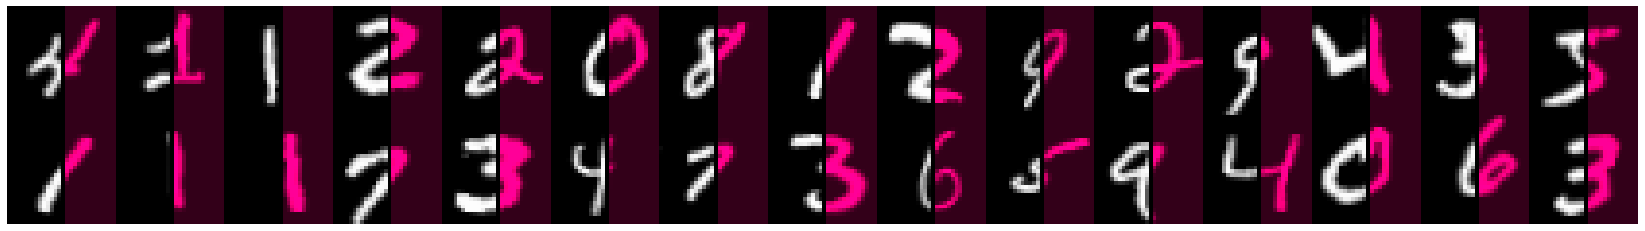

In [39]:
def show_images(pairs):
    n = len(pairs)
    width = 15
    rows = (n-1) // width + 1
    cols = min(n, width)
    bigim = np.zeros((28*rows, 28*cols, 3), np.float32)
    fig = plt.figure(figsize=(2*cols, 2*rows))
    for (j,(x,y)) in enumerate(pairs):
        im = np.zeros((28,28,3))
        im[np.squeeze(x_mask),0:1] = x[np.squeeze(x_mask)]+0.2
        im[np.squeeze(x_mask),2:3] = x[np.squeeze(x_mask)]*0.5+0.1
        im[np.squeeze(y_mask),:] = y[np.squeeze(y_mask)]
        a = (j % width)*28
        b = (j // width)*28
        bigim[b:b+28,a:a+28,:] = im
        
    plt.imshow(bigim)
    plt.axis('off')
    
num = 30
examples = datagen.flow(train_images[:num], dummy[:num], batch_size=num)[0][0]
    
show_images([(examples[i], examples[i]) for i in range(num)])


We build two convolutional neural nets, each acting on a different part of the image (defined by x_mask and y_mask). 

In [40]:
def build_model():
    def cnn(image, mask):
        x = Lambda(lambda y: y * mask.astype(np.float32))(image)
        x = Conv2D(32, kernel_size=(3, 3), strides=(1,1), activation='relu')(x)
        x = Conv2D(64, kernel_size=(4, 4), strides=(2,2), activation='relu')(x)
        x = Conv2D(64, kernel_size=(3, 3), strides=(1,1), activation='relu')(x)
        x = Conv2D(128, kernel_size=(4, 4), strides=(2,2), activation='relu')(x)
        x = Flatten()(x)
        x = Dense(1024, activation='relu')(x)
        features = Dense(num_feat, activation='tanh')(x)
        return features

    image = Input(shape=(28,28,1))
    out1 = cnn(image, x_mask)
    out2 = cnn(image, y_mask)

    # We will use each models separately for predictions...
    feat1 = Model(inputs=image, outputs=out1)
    feat2 = Model(inputs=image, outputs=out2)

    # ...but together for training as they have a joint loss function
    model = Model(inputs=image, outputs=concatenate([out1, out2], axis=1))
    
    return feat1, feat2, model

Here are the functions implementing the RFA objective as well as the inference step:

In [41]:
def tf_prep(T):
    z = tf.math.sqrt(tf.cast(tf.shape(T)[0], tf.float64))
    return tf.cast(T, tf.float64)/z
    
def prep(T):
    z = np.sqrt(T.shape[0])
    return T.astype(np.float64)/z

if fast:
    def pinv(T):
        D = fudge * tf.eye(tf.shape(T)[0], dtype = tf.float64)
        return tl.inv(T + D)
else:
    import tensorflow_probability as tfp
    pinv = tfp.math.pinv

@tf.custom_gradient
def tf_relevance(F, G):  
    F = tf_prep(F)
    G = tf_prep(G)
    D = fudge * tf.eye(tf.shape(F)[1], dtype = tf.float64)

    iK = pinv(tl.transpose(F) @ F)
    iL = pinv(tl.transpose(G) @ G)
    
    A = tl.transpose(F) @ G
    U = iK @ A
    V = iL @ tl.transpose(A)

    dF = 2 * (G - F @ U) @ V @ iK
    dG = 2 * (F - G @ V) @ U @ iL
    grad = lambda delta: (tf.cast(delta * dF, tf.float32), tf.cast(delta * dG, tf.float32))
        
    return tl.trace(U @ V), grad

def cov(F, G):
    F = prep(F)
    G = prep(G)
    return (np.transpose(F) @ F, 
            np.transpose(G) @ G, 
            np.transpose(F) @ G)
    

# produces a function that maps a vector of features on X to the inferred (expected) value of Y
# More generally, Y can be the value of any function f of Y applied to each training example. 
# It's shape is (num training example, a,b,...) where (a,b,...) is the shape of the output of f.
def inferY(ker, G, Y):  
    n, k = F.shape
    data_shape = Y.shape[1:]
    
    K, L, A = ker
    Y = prep(Y).reshape((n,-1))
    G = prep(G)
    
    M = (np.transpose(Y) @ G) @ nl.solve(L, np.transpose(A)) 
    iK = nl.pinv(K)

    def infer(tF):
        X = np.transpose(M @ (iK @ np.transpose(tF))) 
        return X.reshape((-1,) + data_shape)
    
    return infer

# in principle the above works for inferring the full pixel-pixel covariance matrix, 
# but it's not practical. So we have to do that differently:
def inferY2(ker, G, Y):  
    n, k = F.shape
    data_shape = Y.shape[1:]
    
    K, L, A = ker
    Y = prep(Y).reshape((n,-1))
    m = Y.shape[1]
    G = prep(G)
    
    Y2G = np.zeros((m,m,k), np.float32)
    for i in range(k): 
        print(i+1,"/",k,end="\r")
        Y2G[:,:,i] = np.transpose(Y) @ (Y * G[:, i:i+1]) * np.sqrt(n)
        
    M = Y2G @ nl.solve(L, np.transpose(A)) 
    
    iK = nl.pinv(K)
    
    def infer(tF):
        X = np.transpose(M @ (iK @ np.transpose(tF))) 
        return X.reshape((-1,) + data_shape + data_shape)
    
    return infer

# produces a function which maps a vector of features on Y to the inferred (expected) value of X
def inferX(ker, F, X): 
    K, L, A = ker
    return inferY((L, K, np.transpose(A)), F, X)

def singvals(ker):
    K, L, A = ker
    M = nl.solve(K, A) @ nl.solve(L, np.transpose(A))
    return sorted(nl.eigvals(M), reverse=True)
    
def RFA_Loss():
    def loss(dummy, features):
        F, G = tf.split(features, 2, axis=1)
        return -tf_relevance(F, G) 
    return loss

It's time to learn the correlations

In [42]:
feat1, feat2, model = build_model()

model.compile(optimizer = Adam(lr=0.001), loss = RFA_Loss())

name = 'k'+str(num_feat)+'_'

if load:
    model.load_weights(name+'best_weights.h5')
    with open(name+'history.p', 'rb') as handle: 
        history = pickle.load(handle)

else:
    callbacks = [
        ModelCheckpoint(name+'best_weights.h5', monitor='val_loss', mode='min', verbose=0, save_best_only=True, save_weights_only=True),
        #EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=2)
    ]
    
    train_data = datagen.flow(train_images, dummy, batch_size=batch_size, shuffle=True)
    test_data = test_datagen.flow(test_images, test_dummy, batch_size=batch_size)
    
    history = model.fit_generator(train_data, steps_per_epoch = len(train_images) / batch_size,
                        epochs = max_epoch, verbose=1,
                        callbacks = callbacks,
                        validation_data = test_data, validation_freq = 5).history
    
    with open(name+'history.p', 'wb') as handle: 
        pickle.dump(history, handle)
    
    model.save_weights(name+'last_weights.h5')
    model.load_weights(name+'best_weights.h5')

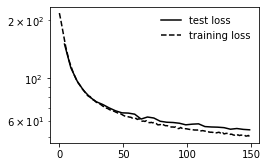

In [43]:
plt.figure(figsize=(3*1.25,2*1.25))
plt.semilogy(np.arange(len(history['val_loss']))*5+4, num_feat + np.array(history['val_loss']), 'k-')
plt.semilogy(num_feat + np.array(history['loss']), 'k--')
#plt.ylabel('Loss')
#plt.xlabel('Epoch')
plt.legend(['test loss', 'training loss'], loc='upper right', frameon=False)
plt.savefig("halves_loss.pdf")
plt.show()

We compute the best features on the full training set

In [44]:
post_data = datagen.flow(train_images, batch_size=batch_size)

aux = []
for j in range(2):
    aux += [post_data[i] for i in range(len(post_data))]

post_images = np.concatenate(aux, axis=0)

#features = model.predict_generator(post_data, verbose=1) 
features = model.predict(post_images, batch_size=2000, verbose=1) 

F, G = np.split(features, 2, axis=1)
ker = cov(F, G)

120000/120000 [==============================] - 11s 95us/sample


A little consistency check: we compute the singular values using different random batches. The result shouldn't depend too much on the sample size. This screens for a failure mode in which the objective is independent of the sample for a given sample size, but highly dependent on the sample size.

199.60120368341862


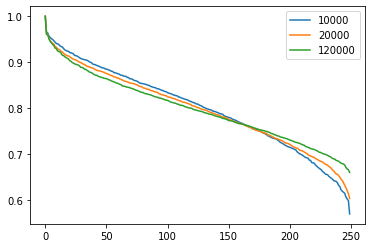

In [45]:
#if not load:
for n in [10000, 20000]:
    sample = np.random.choice(F.shape[0], n)
    plt.plot(np.abs(singvals(cov(F[sample], G[sample]))), label=str(n))
    
sv = singvals(ker)
print(sum(sv))

with open(name+'train_singvals.p', 'wb') as handle: 
    pickle.dump(sv, handle)
    
plt.plot(np.abs(sv), label=str(len(F)))

plt.legend();

Let's graph the singular values evaluated on test data

50000/50000 [==============================] - 5s 93us/sample
195.2926718170409


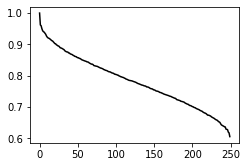

In [46]:
test_data = test_datagen.flow(test_images, batch_size=2000)

aux = []
for j in range(5):
    aux += [test_data[i] for i in range(len(test_data))]

test_data = np.concatenate(aux, axis=0)

tfeatures = model.predict(test_data, batch_size=2000, verbose=1) 
tF, tG = np.split(tfeatures, 2, axis=1)


tker = cov(tF, tG)
sv = np.abs(singvals(tker))
print(sum(sv))

with open(name+'singvals.p', 'wb') as handle: 
    pickle.dump(sv, handle)
        
plt.figure(figsize=(3*1.25,2*1.25))
plt.plot(np.abs(sv), 'k-');
#plt.savefig("halves_lambda.pdf")


Finally, we can try inferring one part of test images given their other part (in red). These are meant to be averages over all possibilities, not samples from the conditional distributions.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


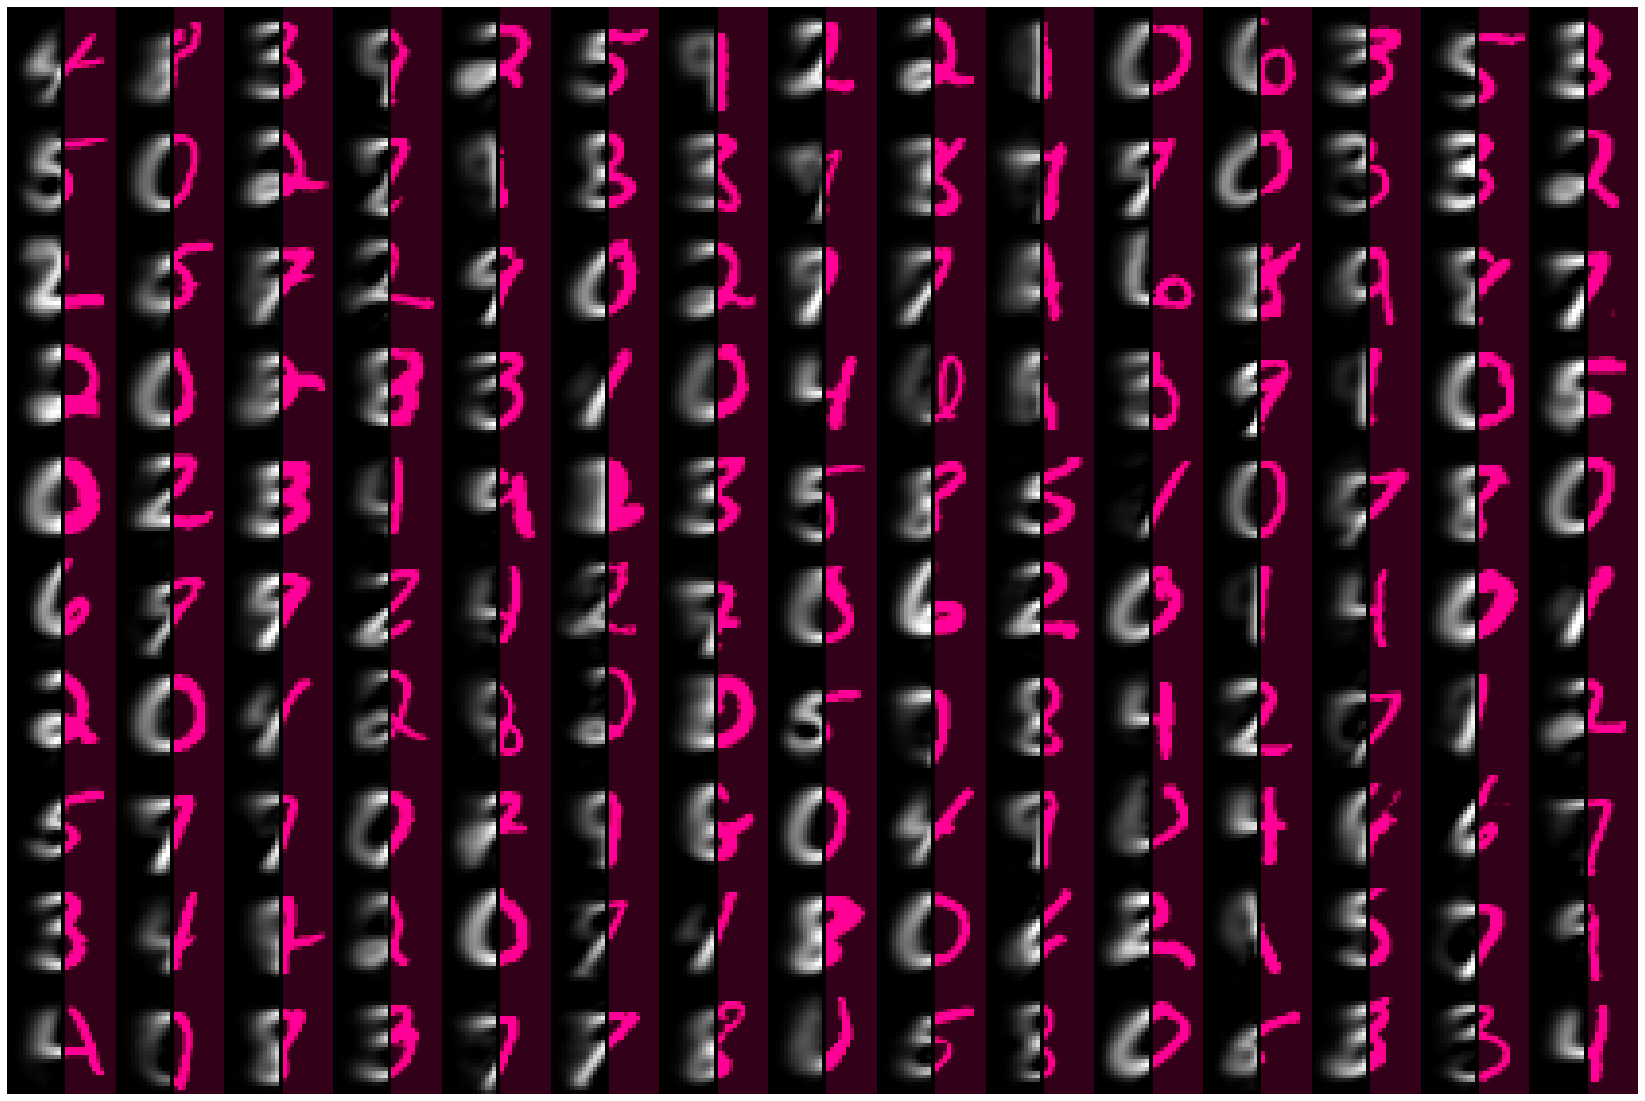

In [47]:
# make function that predicts conditional mean of pixel value
infer = inferY(ker, G, post_images * y_mask)

# try it on a sample of test images
np.random.seed(1337)
samples = np.random.choice(test_images.shape[0], size=15*10, replace=False)

sF = feat1.predict(test_images[samples], verbose=0)
y_pred = infer(sF)
#y_pred = infer(tF[samples])
show_images(list(zip(test_images[samples], y_pred))) 

Okay, but maybe a traditional feed-forward encoder-decoder might have done just as well. However, we have a full probabilist model. For instance, let us check the uncertainty on each pixel values:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


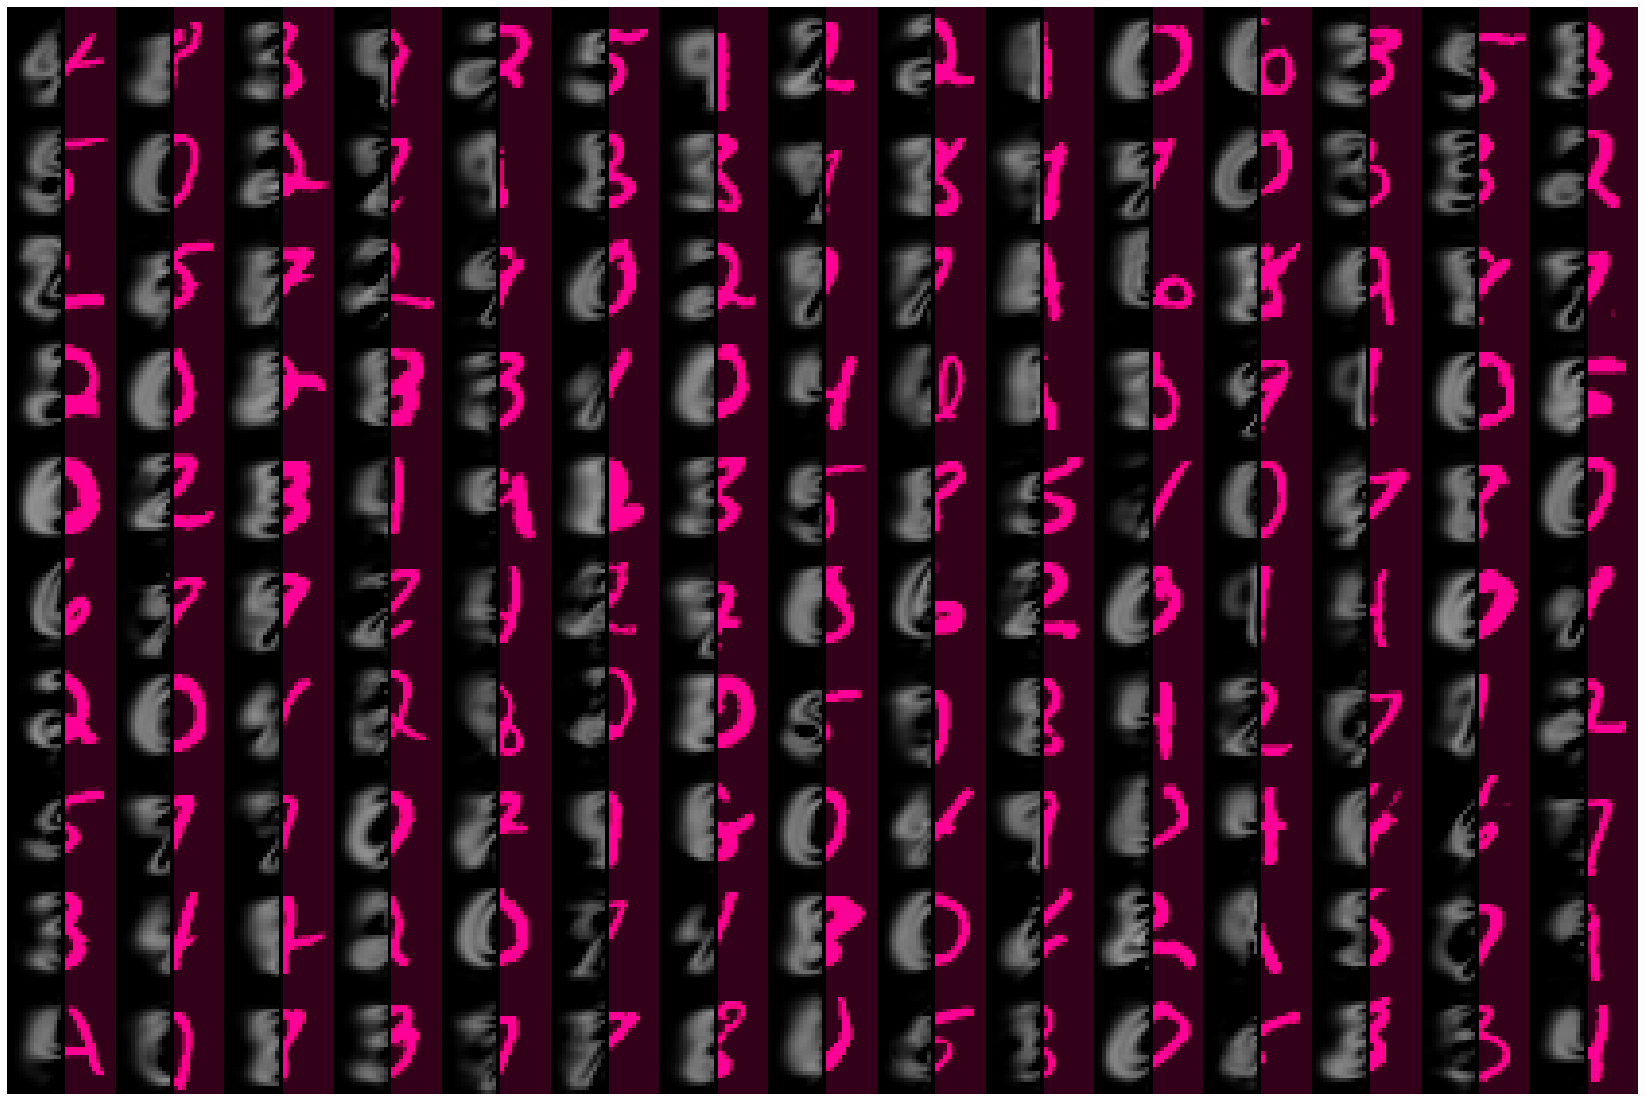

In [48]:
# predict the mean of the square of the pixel values
infer2_local = inferY(ker, G, (post_images * y_mask)**2)

y2_pred = infer2_local(sF)

# that allows us to compute the standard deviations
dev = y2_pred - y_pred**2
show_images(list(zip(test_images[samples], dev*3)))

Even better, we can predict all pixel-pixel correlations!

In [49]:
infer2 = inferY2(ker, G, post_images * y_mask)

And uncover the main predictions ambiguities by exploring variations in the direction of largest covariance

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


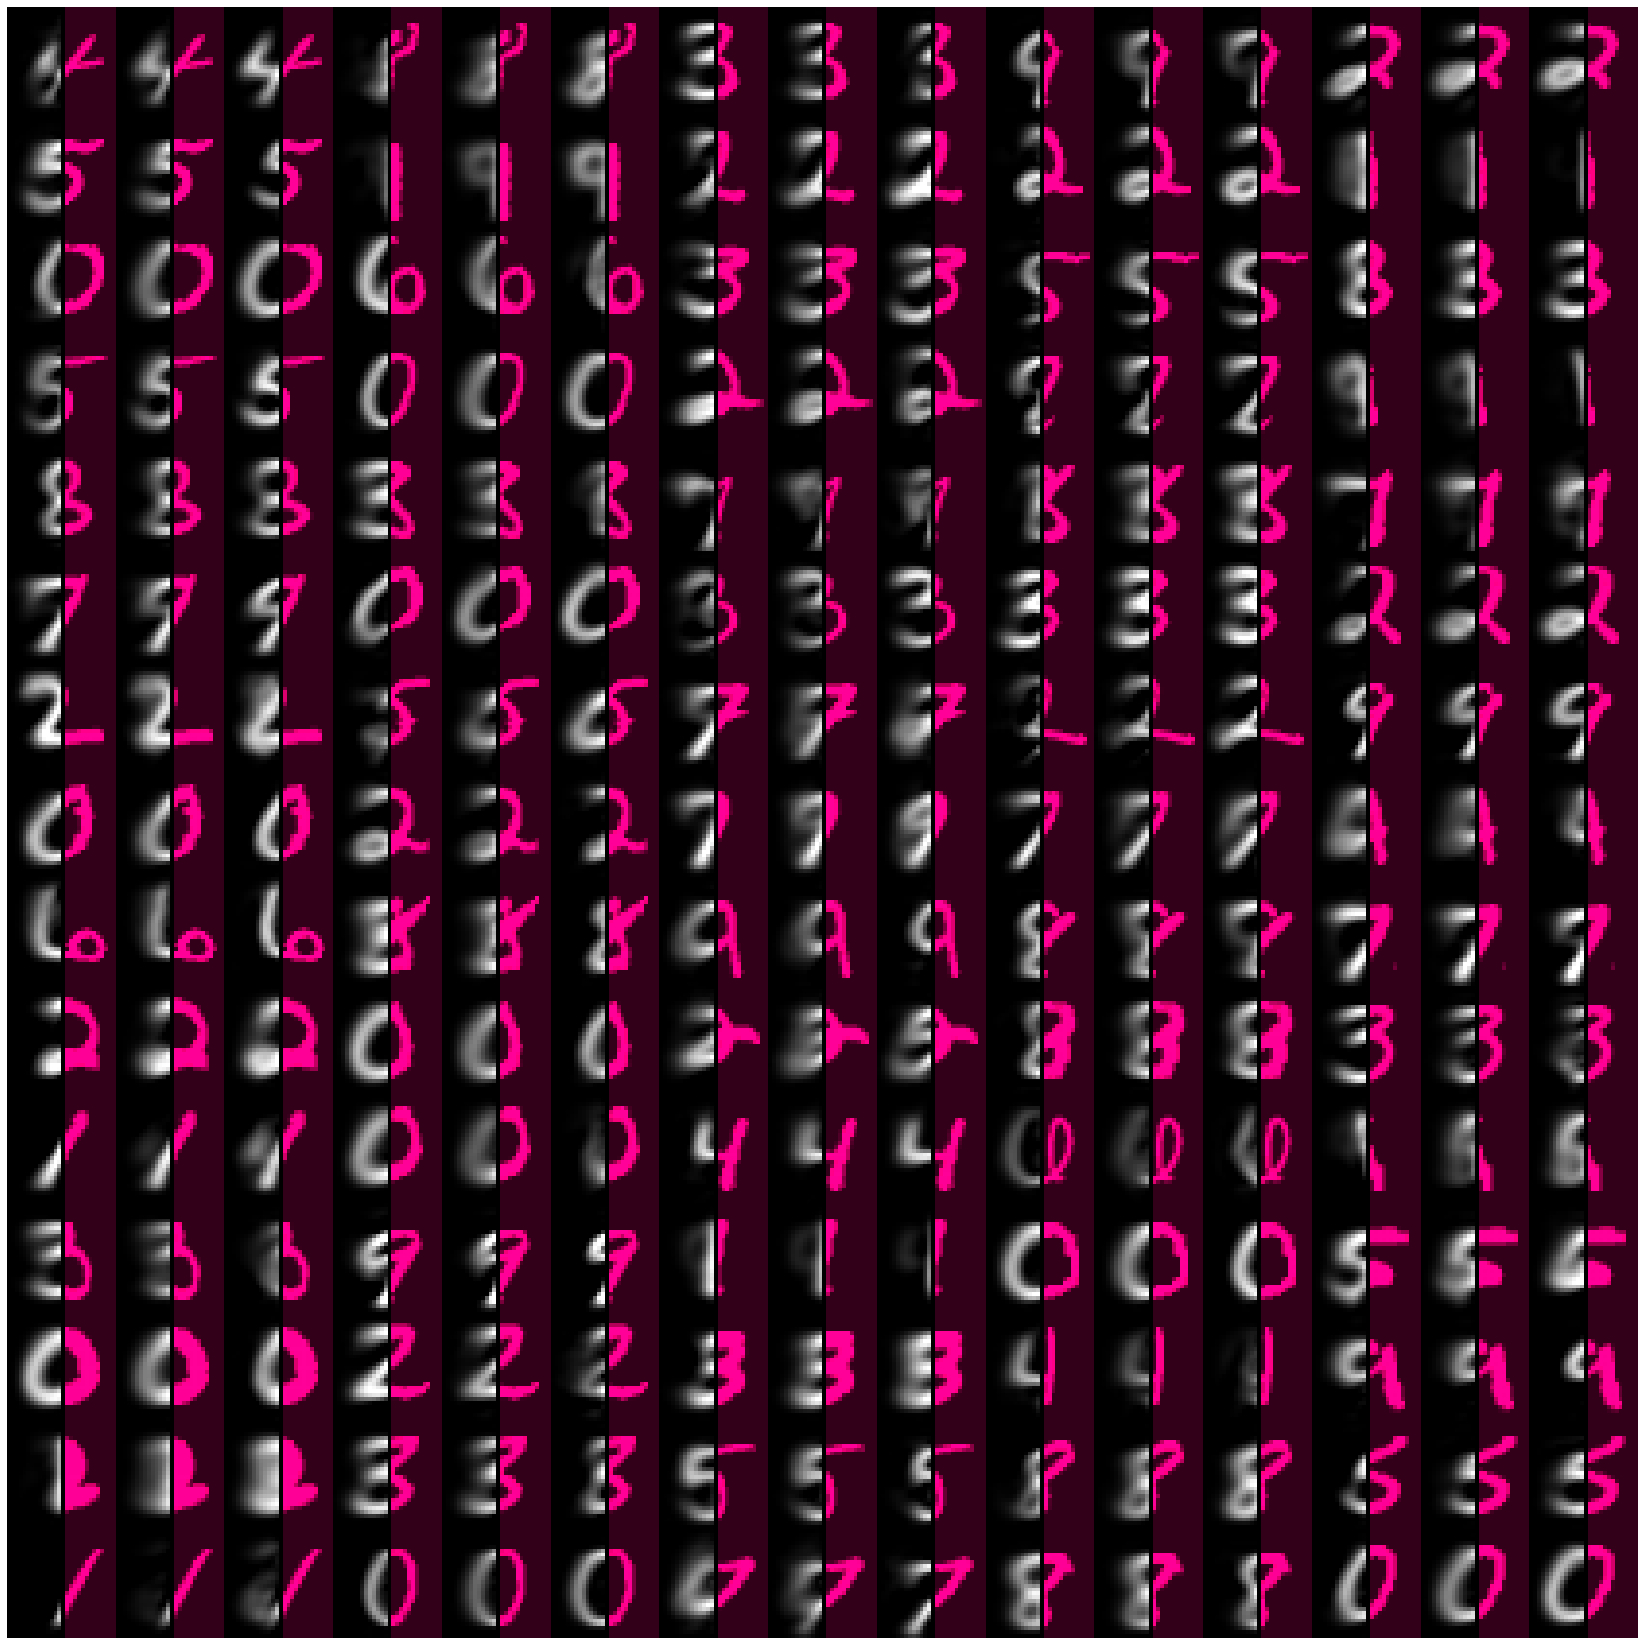

In [50]:
s = 28**2
y2_pred = infer2(sF)
left_images = []
right_images = []
for i in range(5*15):
    print(i+1,"/",5*15,end="\r")
    y = y_pred[i]
    y2 = y2_pred[i]
    a, ef = nl.eigh(y2.reshape((s,s)) - y.reshape((s,1)) * y.reshape((1,s)))
    idx = a.argsort()[::-1]
    alpha = np.sqrt(a[idx[0]])                     # largest eigenvalue
    vec = ef[:,idx[0]].reshape((28,28,1))          # corresponding eigenvector 
    vec = vec/nl.norm(vec)
    left_images.append(y - alpha*vec)
    left_images.append(y)
    left_images.append(y + alpha*vec)
    for j in range(3): right_images.append(test_images[samples[i]])

show_images(list(zip(right_images, left_images)))